# Anomalous diffusion from normal diffusion
> We show how to study anomalous diffusion by characterizing the Brownian motion properties through time.

In [ ]:
#| hide
from step.data import *
from step.models import *
from step.utils import *
from step.baselines import diffusion_coefficient_tamsd, ruptures_cp

from fastai.vision.all import *

The main goal of this tutorial is to show how we can detect the emergence of anomalous diffusion with an accurate description of the diffusion coefficient through time.
This kind of analysis provides us with much richer information about the underlying physical processes in the system than methods that simply extract a global anomalous diffusion exponent from the trajectories.

# Load the model
First of all, we need to load a trained model with which to perform the analysis.

::: {.callout-note}
We refer to the [model training tutorial](https://borjarequena.github.io/step/tutorials/model_training.html) for details about how to train and save your models.
:::

To load the models within a `Leaner`, we need to provide some data loaders. However, we will use the model to study various scenarios, so we provide an empty dataloader and load the different data sets as we need them.

In [ ]:
dim = 2
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets
model = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], pos_enc=False,
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-3.1, 3.1))
model.to(default_device())
learn_diff = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

Now we can load the trained model weights.

In [ ]:
learn_diff.load(f'xresattn_bm_{dim}d_1_to_4cp')
learn_diff.model.eval();

::: {.callout-warning}
It is very important to define the model exactly with the same layers as we did during training. Otherwise, we won't be able to load the trained parameters!
:::

# Scaled Brownian motion

Scaled Brownian motion (SBM) trajectories present an aging phenomenon that results in a continuous change of the diffusion coefficient with time.
The time-dependent diffusion coefficient follows a power-law relationship $D(t)\sim t^{\alpha-1}$ with the time, where $\alpha$ is the anomalous diffusion exponent.

In biological contexts, this model is associated, for example, with crowded environments that result in sub-diffusion ($\alpha<1$).

## Generate the data

Let's generate SBM trajectories for a couple of anomalous diffusion exponents $\alpha=0.1, 0.5$.

SBM is model number 4, following the [AnDi datasets](https://github.com/AnDiChallenge/andi_datasets) convention.
We can see that in the `MODEL_DATA` dictionary.

In [ ]:
MODEL_DATA

{0: {'name': 'attm', 'exps': (0.05, 1.0)},
 1: {'name': 'ctrw', 'exps': (0.05, 1.0)},
 2: {'name': 'fbm', 'exps': (0.05, 1.95)},
 3: {'name': 'lw', 'exps': (1.05, 2.0)},
 4: {'name': 'sbm', 'exps': (0.05, 2.0)}}

For this analysis, we will create 3000 trajectories for each $\alpha$ of 200 time steps.

In [ ]:
n_traj, max_t, exponents, models, dim = 6000, 200, np.array([0.1, 0.5]), [4], 2
trajs = create_trajectories(n_traj, max_t, exponents, models, dim, noise=None)
trajs = tensor(trajs[:, 2:].reshape((n_traj, dim, max_t)).transpose(0, 2, 1))

## Extract the diffusion coefficient

Let's predict the diffusion coefficient for these trajectories.
We will compare the results obtained with STEP with the diffusion coefficient obtained from a linear fit of the time-averaged mean squared displacement (TA-MSD) over a sliding window of 20 time steps along the trajectories.

Let's start with STEP. In order to speed things up, we can group the trajectories in batches.

In [ ]:
bs = 128
n_batch = np.ceil(n_traj/bs).astype(int)
batches = [trajs[i*bs:(i+1)*bs] for i in range(n_batch)]

In [ ]:
preds_step = [to_detach(learn_diff.model(xb.cuda()).squeeze()) for xb in batches]
preds_step = torch.cat(preds_step, axis=0)

Now we can proceed with the TA-MSD fit over a sliding window.

In [ ]:
def swin_D_tmsd(x, win_size=20):
    "Computes the anomalous exponent with a sliding window over x."
    return np.array([diffusion_coefficient_tamsd(x[i:i + win_size], t_lag=[1, 2])
                     for i in range(len(x) - win_size)])

In [ ]:
preds_tamsd = tensor([swin_D_tmsd(t) for t in trajs])  # Can take a couple of minutes

Let's see the results!

Text(0.5, 0, 't')

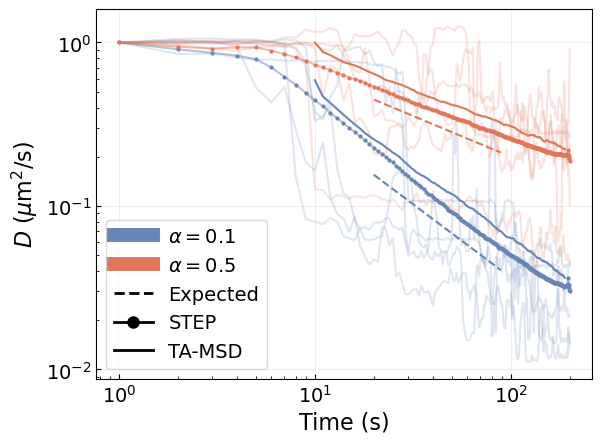

In [ ]:
#| code-fold: true
from matplotlib.lines import Line2D

idx = n_traj // 2
sbm01_step = 10**(preds_step[:idx]).mean(0)
sbm01_tamsd = preds_tamsd[:idx].mean(0)
sbm05_step = 10**(preds_step[idx:]).mean(0)
sbm05_tamsd = preds_tamsd[idx:].mean(0)

x_step = np.arange(max_t) + 1
win_size = max_t - sbm01_tamsd.shape[0]
x_tamsd = np.arange(win_size//2, max_t - win_size//2)

# ALPHA = 0.1
for t in preds_step[:5, :]:
    t = 10**t
    t = t/t[0]
    plt.loglog(x_step, t, c=colors[0], alpha=0.2)
    
plt.loglog(x_step, sbm01_step/sbm01_step[0], c=colors[0], label=r'$\alpha = 0.1$', marker='o', ms=2, lw=0)
plt.loglog(x_step, sbm01_step/sbm01_step[0], c=colors[0], alpha=0.5)
plt.loglog(x_tamsd, sbm01_tamsd/sbm01_tamsd[0]/1.7, c=colors[0])  # Rescale by 1/1.7 to bring lines close
    
# ALPHA = 0.5
for t in preds_step[-5:, :]:
    t = 10**t
    t = t/t[0]
    plt.loglog(x_step, t, c=colors[1], alpha=0.2)

plt.loglog(x_step, sbm05/sbm05[0], c=colors[1], marker='o', ms=2, lw=0)
plt.loglog(x_step, sbm05/sbm05[0], c=colors[1], alpha=0.5)
plt.loglog(x_tamsd, sbm05_tamsd/sbm05_tamsd[0], c=colors[1])

# Analytical scaling
alpha = 0.1
init, end = 20, 90
plt.plot(np.arange(init, end), 2.3*np.arange(init, end)**(0.1 - 1), c=colors[0], ls='--')
plt.plot(np.arange(init, end), 2*np.arange(init, end)**(0.5 - 1), c=colors[1], ls='--')


plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("$D$ " + D_units, fontsize=16)

plt.grid(alpha=alpha_grid)
legend_elements = [Line2D([0], [0], color=colors[0], lw=10, label=r'$\alpha = 0.1$'),
                   Line2D([0], [0], color=colors[1], lw=10, label=r'$\alpha = 0.5$'),
                   Line2D([0], [0], color="k", lw=2, linestyle="dashed", label=r'Expected'),
                   Line2D([0], [0], color="k", marker='o', lw=2, markersize=8, label=r'STEP'),
                   Line2D([0], [0], color="k", lw=2, label=r'TA-MSD')]
plt.legend(handles=legend_elements, fontsize=14)

plt.tick_params(direction='in')
plt.tick_params(which='minor', direction='in')
plt.tick_params(labelsize=14);

We see that, even though our model has not been trained to predict smooth changes in $D$, it can capture the phenomenon on average.
Both STEP and the TA-MSD with a sliding window allow us to recover the expected power-law scaling $D(t)\propto t^{\alpha}$.

Finally, we can save our results for the future.

In [ ]:
file_name = "preds_sbm"
data_path = DATA_PATH/file_name
with open(data_path.with_suffix('.pkl'), 'wb') as f:
    pickle.dump({"step": preds_step, "tamsd": preds_tamsd}, f, protocol=pickle.HIGHEST_PROTOCOL)

# Annealed transit-time model

Coming soon!